In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

In [2]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

In [3]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

In [4]:
def back_step_reduction(graph):
    visited_edges = set()
    walked_edges = []
    nodes = list(graph.nodes())
    
    current_node = random.choice(nodes)
    while len(visited_edges) < graph.number_of_edges():
        neighbors = list(graph.neighbors(current_node))
        weights = [graph[current_node][neighbor].get('weight', 1) for neighbor in neighbors]
        if len(weights) == 0:
            print("some fuckery")
            visualize_graph(graph)

        # Normalize weights to create probabilities
        try:
            probabilities = [weight / sum(weights) for weight in weights]
        except:
            print(weights)
            return
            

        next_node = random.choices(neighbors, weights=probabilities)[0]
        edge = (min(current_node, next_node), max(current_node, next_node))

        visited_edges.add(edge)
        walked_edges.append(edge)
        #print(f"Visited edge: {edge}")
        
        graph[current_node][next_node]['weight'] = np.sqrt(graph[current_node][next_node]['weight'])
        
        
        current_node = next_node

    return walked_edges

In [5]:
def centrality_based_walk(graph):
    visited_edges = set()
    walked_edges = []
    nodes = list(graph.nodes())
    
    current_node = random.choice(nodes)
    while len(visited_edges) < graph.number_of_edges():
        neighbors = list(graph.neighbors(current_node))
        weights = [graph[current_node][neighbor].get('weight', 1) for neighbor in neighbors]
        if len(weights) == 0:
            print("some fuckery")
            visualize_graph(graph)

        # Normalize weights to create probabilities
        try:
            probabilities = [weight / sum(weights) for weight in weights]
        except:
            print(weights)
            return
            

        next_node = random.choices(neighbors, weights=probabilities)[0]
        edge = (min(current_node, next_node), max(current_node, next_node))

        visited_edges.add(edge)
        walked_edges.append(edge)
        #print(f"Visited edge: {edge}")
        
        
        
        current_node = next_node

    return walked_edges

In [6]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        else:
            print(f"Edge {edge} not found in the graph.")

In [9]:
UN_walks = []
PR_walks = []
edge_count = []

for i in range(10,50):
    tmp_un = []
    tmp_pr = []
    tmp_e = []
    
    for j in range(10):
        G = generate_sf_graph(i)
        tmp_e.append(G.number_of_edges())
        L_G = nx.line_graph(G)
        PR = nx.pagerank(L_G,max_iter=i*10)
        UN = vertex_dict = {vertex: 0.001 for vertex in L_G.nodes()}

        U_G = copy.deepcopy(G)
        P_G = copy.deepcopy(G)
        add_weights_to_edges_from_dict(U_G,UN)
        add_weights_to_edges_from_dict(P_G,PR)
        u_tmp =[]
        for k in range(10):
            tmp=copy.deepcopy(U_G)
            u_tmp.append(len(back_step_reduction(tmp)))
        pr_tmp = []
        for k in range(10):
            tmp=copy.deepcopy(P_G)
            pr_tmp.append(len(centrality_based_walk(tmp)))
        tmp_un.append(u_tmp)
        tmp_pr.append(pr_tmp)
    edge_count.append(tmp_e)
    
    UN_walks.append(tmp_un)
    PR_walks.append(tmp_pr)

In [10]:
np_u = []
np_p = []
for i in range(len(UN_walks)):    
    tmp = np.concatenate(UN_walks[i])
    np_u.append(tmp)
    tmp = np.concatenate(PR_walks[i])
    np_p.append(tmp)
np_u = np.array(np_u)
np_p = np.array(np_p)
np_e = np.array(edge_count)
print(np_p)

[[ 38  41  46 ...  52  82  94]
 [ 62  64  75 ...  72  91  58]
 [ 80  71  99 ...  53 174 110]
 ...
 [503 634 959 ... 585 445 555]
 [615 662 564 ... 581 781 549]
 [670 511 496 ... 348 539 569]]


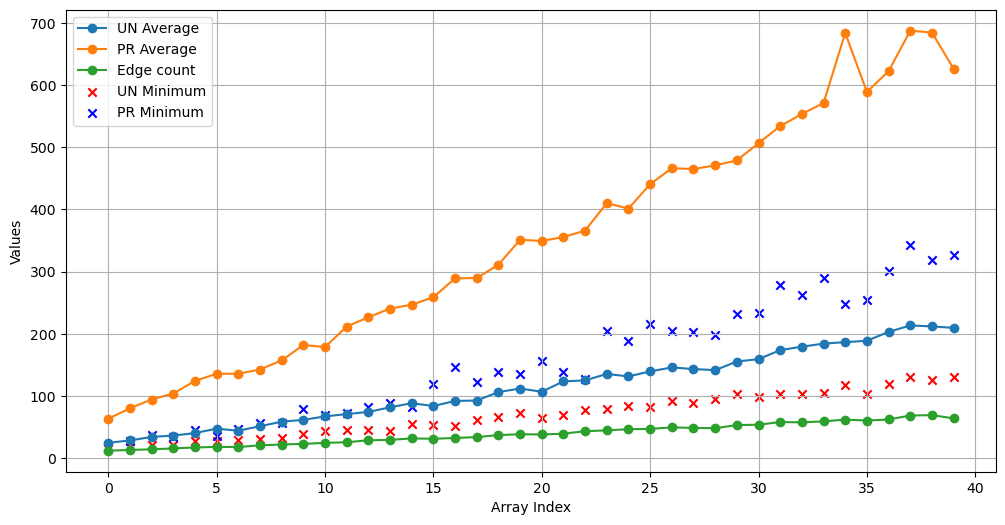

In [11]:



avg_r = np.mean(np_u,axis=1)
avg_p = np.mean(np_p,axis=1)

min_r = np.min(np_u,axis=1)
min_p = np.min(np_p,axis=1)

np_e = np.mean(np_e,axis=1)

plt.figure(figsize=(12, 6))

plt.plot( avg_r, label='UN Average', marker='o')
plt.plot( avg_p, label='PR Average', marker='o')
plt.plot( np_e, label='Edge count', marker='o')

# Plot minimums
plt.scatter(range(len(min_r)), min_r, color='red', label='UN Minimum', marker='x')
plt.scatter(range(len(min_p)), min_p, color='blue', label='PR Minimum', marker='x')

plt.xlabel('Array Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


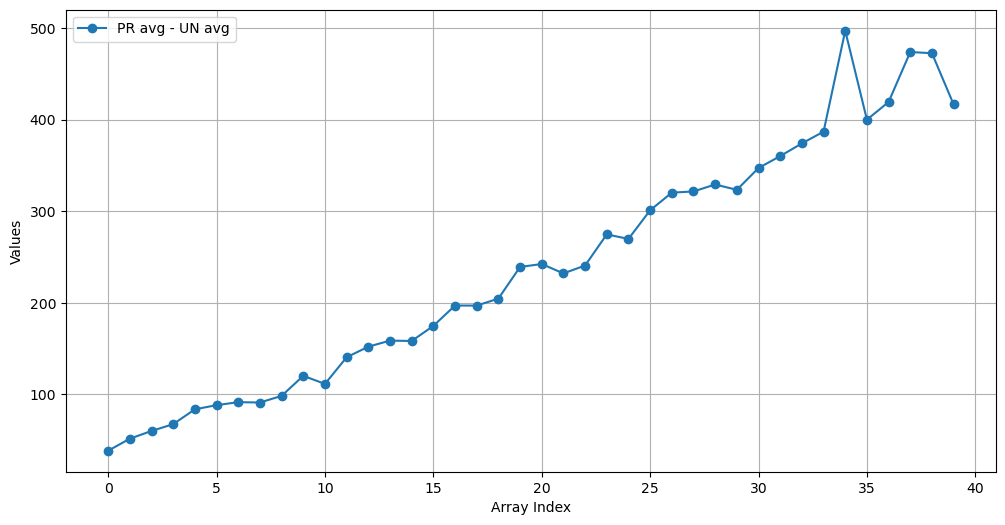

In [12]:
avg_diff = []
min_diff = []
for i in range(len(UN_walks)):
    avg_diff.append((np.average(np_p[i]) - np.average(np_u[i])))
    min_diff.append((min(np_p[i]) - min(np_u[i])))
    
plt.figure(figsize=(12, 6))

plt.plot( avg_diff, label='PR avg - UN avg', marker='o')
#plt.plot( min_diff, label='PR min - UN min', marker='o')

plt.xlabel('Array Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


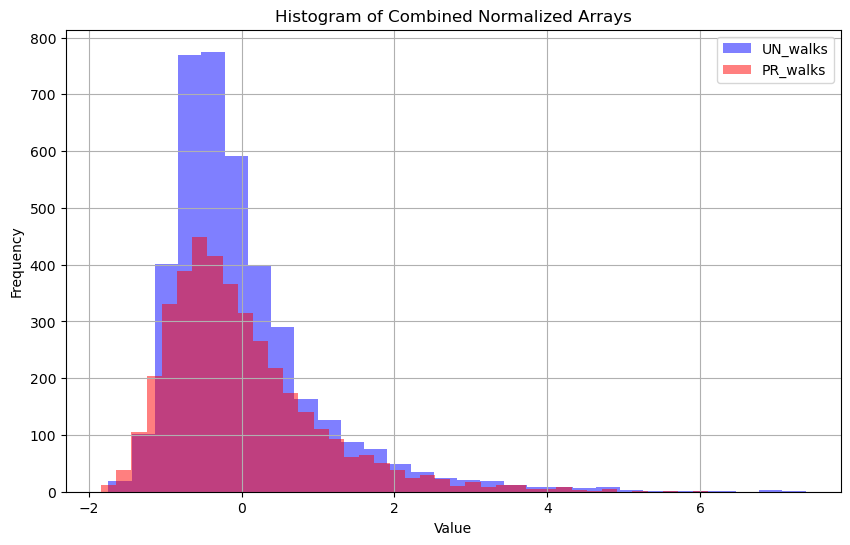

In [13]:
# Apply z-score normalization to each array individually for UN_walks
normalized_UN_walks = [(array - np.mean(array)) / np.std(array) for array in np_u]

# Apply z-score normalization to each array individually for PR_walks
normalized_PR_walks = [(array - np.mean(array)) / np.std(array) for array in np_p]

# Combine the normalized arrays into a single array
combined_normalized_array = np.concatenate(normalized_UN_walks + normalized_PR_walks)

# Plotting histogram
plt.figure(figsize=(10, 6))

# Histogram for UN_walks
plt.hist(np.concatenate(normalized_UN_walks), bins=30, alpha=0.5, color='blue', label='UN_walks')

# Histogram for PR_walks
plt.hist(np.concatenate(normalized_PR_walks), bins=40, alpha=0.5, color='red', label='PR_walks')

plt.title('Histogram of Combined Normalized Arrays')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()